In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import os

# PyTorch
import torch

# PyTorch - Neural Networks
import torch.nn as nn
from torch import nn

# PyTorch - Gradient Descent Optimizers
from torch import optim

# PyTorch - Others
from torchvision import datasets, transforms, models
import torchvision.transforms as transform
import torchvision.models as models
import torch.nn.functional as F

# Warnings off
import warnings
warnings.filterwarnings("ignore")

# Fix a seed for PyTorch
torch.manual_seed(42);

In [ ]:
gpu = True

if gpu == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:

!unzip '/content/drive/MyDrive/archive (6).zip'

Streaming output truncated to the last 5000 lines.
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0435-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0437-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0438-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0439-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0440-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0441-0001.jpeg  
  inflating: Pediatric Chest X-ray Pneumonia/train/NORMAL/IM-0442-

In [ ]:
!ls /content

 drive	'Pediatric Chest X-ray Pneumonia'   person1_virus_13.jpeg   sample_data


In [ ]:

%cd Pediatric Chest X-ray Pneumonia

/content/Pediatric Chest X-ray Pneumonia


Found 1349 elements for NORMAL
Found 3883 elements for PNEUMONIA


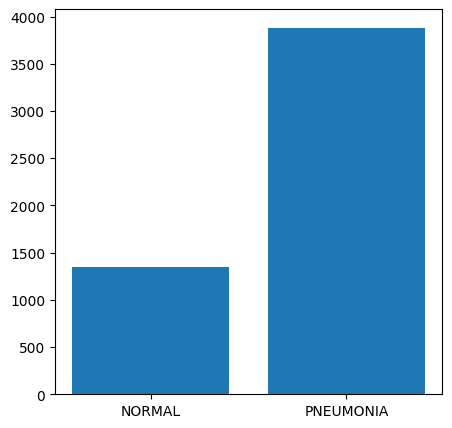

In [ ]:
# Set counters
n_samples_nr_train = len(os.listdir('train/NORMAL'))
n_samples_pn_train = len(os.listdir('train/PNEUMONIA'))

# Define two dictionaries
class_names = {0: 'NORMAL', 1: 'PNEUMONIA'}
class_count = {0: n_samples_nr_train, 1: n_samples_pn_train}

# Print results
print(f'Found {class_count[0]} elements for {class_names[0]}')
print(f'Found {class_count[1]} elements for {class_names[1]}')

# Barplot
fig, ax = plt.subplots(figsize=(5,5));
ax.bar([class_names[0], class_names[1]], [class_count[0], class_count[1]]);

In [ ]:
# Class weights values
samples_0 = class_count[0]
samples_1 = class_count[1]
tot_samples = samples_0 + samples_1

weight_0 = 1 - samples_0/tot_samples
weight_1 = 1 - weight_0  # equivalent to = 1 - samples_1/tot_samples

# Class weights tensor
class_weights = [weight_0, weight_1]
class_weights = torch.FloatTensor(class_weights)
print(class_weights)

tensor([0.7422, 0.2578])


In [ ]:
data_transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.CenterCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.RandomGrayscale(),
                    transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
                    transforms.ToTensor()])

# Assosciate the dataset and the transformations with ImageFolder
data = datasets.ImageFolder('train', transform = data_transform)
# Split training data in train and validation
train_split, val_split = train_test_split(data, test_size=0.3)

# Print informations
print(f'{len(train_split)} images for training, {len(val_split)} images for validation')

3662 images for training, 1570 images for validation


In [ ]:
batch_size = 64

# Load the datasets with DataLoader
train_loader = torch.utils.data.DataLoader(train_split, batch_size = batch_size, shuffle = True)
val_loader   = torch.utils.data.DataLoader(val_split,   batch_size = batch_size, shuffle = True)

# Class-number association
class_index = {0: 'NORMAL', 1: 'PNEUMONIA'}

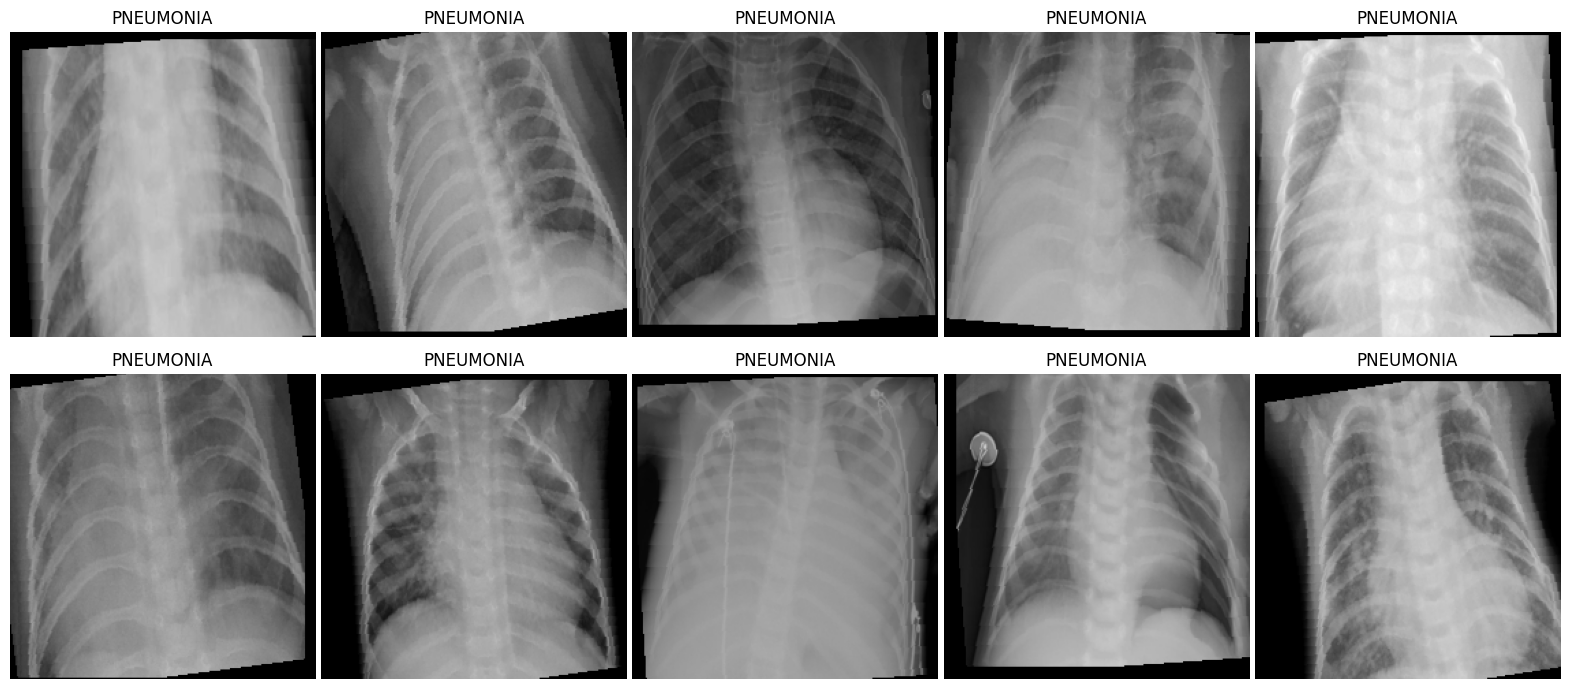

In [ ]:
plt.figure(figsize=(20, 10))
n_rows = 2
n_cols = 5

# Extract images from 'train_loader'
images, labels = next(iter(train_loader))

# Display images
for i in range(n_rows*n_cols):
  plt.subplot(n_rows, n_cols, i+1)
  plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
  plt.title(class_index[labels.numpy()[i]])
  plt.axis('off')

plt.subplots_adjust(wspace=.02, hspace=-.2)

In [ ]:
model = models.densenet161(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 65.8MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
# Important: compatibility problem
# Whatever classifier we put, it will have to have 'model.classifier.in_features' as 'in_features'
model.classifier.in_features

2208

In [ ]:
# Freeze the weights of the pre-trained model
for parameter in model.parameters():
    parameter.requires_grad = False

In [ ]:
# Build a custom classifier
initial_num_neurons = model.classifier.in_features
num_classes = len(class_index)

# New classifier
classifier = nn.Linear(in_features=initial_num_neurons, out_features=num_classes)

# Replace the transfer learning model classifier
model.classifier = classifier

In [ ]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer and learning rate
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Adapter
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim=1)                   # extract the prediction
    num_correct    = torch.sum(predictions == labels).item()     # count how many correct predictions (.item() to obtain a python-number)
    perc_correct   = torch.tensor(num_correct/len(predictions))

    return perc_correct

In [ ]:
def training_step(model, loader, loss_function):

    # Training-mode
    model.train()

    # For every epoch initialize loss and number of correct predictions
    epoch_loss = 0
    epoch_correct = 0


    for images, labels in iter(loader):

        # Load images and labels to 'device'
        images, labels = images.to(device), labels.to(device)

        # Initialize the gradient
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):

            # Output from the model (from the forward pass)
            output = model(images)

            # Calculate the loss_function for the current batch
            loss = loss_function(output, labels)

            # Perform the backpropagation (backpropagate the error)
            loss.backward()

            # Gradient descent step to update parameters (weights/biases)
            optimizer.step()

            # Extract predictions
            _, predictions = torch.max(output, dim=1)


        # Update loss (+= loss * num_images_in_the_batch)
        # (.item(): returns the value of the tensor as a standard number)
        epoch_loss += loss.item()*images.size(0)

        # Update correct
        epoch_correct += torch.sum(predictions == labels)


    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)

    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

In [ ]:
def evaluate_model(model, loader, loss_function):

    # Evaluation-mode
    model.eval()

    # For every epoch initialize loss and number of correct predictions
    epoch_loss = 0
    epoch_correct = 0

    #---------------------------------------------------------- Batch-loop ---------#
    for images, labels in iter(loader):                                             #
                                                                                    #
        # Load images and labels to 'device'                                        #
        images, labels = images.to(device), labels.to(device)                       #
                                                                                    #
        #------------------------------------------------------ Evaluation ----#    #
        with torch.set_grad_enabled(False):                                    #    #
                                                                               #    #
            # Output from the model (from the forward pass)                    #    #
            output = model(images)                                             #    #
                                                                               #    #
            # Calculate the loss_function for the current batch                #    #
            loss = loss_function(output, labels)                               #    #
                                                                               #    #
            # Extract predictions                                              #    #
            _, predictions = torch.max(output, dim=1)                          #    #
        #----------------------------------------------------------------------#    #
                                                                                    #
        # Update loss (+= loss * num_images_in_the_batch)                           #
        # (.item(): returns the value of the tensor as a standard number)           #
        epoch_loss += loss.item()*images.size(0)                                    #
                                                                                    #
        # Update correct                                                            #
        epoch_correct += torch.sum(predictions == labels)                           #
    #-------------------------------------------------------------------------------#

    # Get the right epoch loss (element_loss / n_element)
    epoch_loss = epoch_loss / len(loader.dataset)

    # Accuracy of the current batch (correct / n_samples)
    accuracy = epoch_correct.double() / len(loader.dataset)

    return epoch_loss, accuracy

In [ ]:
# Number of epochs
epochs = 15

# Monitor 'val_loss'
best_val_loss = float('inf')

# Model to device
model.to(device)

# For the records
train_loss_savings = []
train_acc_savings  = []
val_loss_savings   = []
val_acc_savings    = []

# Saving the model
best_model = copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    # Training step
    train_loss, train_acc = training_step(model, train_loader, loss_function)
    train_loss_savings.append(train_loss)
    train_acc_savings.append(train_acc.item())

    # Evaluation step
    val_loss, val_acc = evaluate_model(model, val_loader, loss_function)
    val_loss_savings.append(val_loss)
    val_acc_savings.append(val_acc.item())

    # Print results
    print(f'Epoch: {epoch+1:02}/{epochs} - train_loss: {train_loss:.4f} - train_accuracy: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}')

    # If the val_loss improved, save the model
    if val_loss < best_val_loss:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss improved from {best_val_loss:.4f} to {val_loss:.4f}, new model saved')
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
    else:
        print(f'Epoch: {epoch+1:02}/{epochs} - val_loss did not improve')

    # Update scheduler (learning rate adapter)
    scheduler.step()

Epoch: 01/15 - train_loss: 0.3316 - train_accuracy: 0.8564 - val_loss: 0.2806 - val_accuracy: 0.8631
Epoch: 01/15 - val_loss improved from inf to 0.2806, new model saved
Epoch: 02/15 - train_loss: 0.1889 - train_accuracy: 0.9350 - val_loss: 0.1706 - val_accuracy: 0.9414
Epoch: 02/15 - val_loss improved from 0.2806 to 0.1706, new model saved
Epoch: 03/15 - train_loss: 0.1598 - train_accuracy: 0.9468 - val_loss: 0.1473 - val_accuracy: 0.9503
Epoch: 03/15 - val_loss improved from 0.1706 to 0.1473, new model saved
Epoch: 04/15 - train_loss: 0.1381 - train_accuracy: 0.9506 - val_loss: 0.1384 - val_accuracy: 0.9484
Epoch: 04/15 - val_loss improved from 0.1473 to 0.1384, new model saved
Epoch: 05/15 - train_loss: 0.1231 - train_accuracy: 0.9577 - val_loss: 0.1361 - val_accuracy: 0.9541
Epoch: 05/15 - val_loss improved from 0.1384 to 0.1361, new model saved
Epoch: 06/15 - train_loss: 0.1236 - train_accuracy: 0.9577 - val_loss: 0.1350 - val_accuracy: 0.9548
Epoch: 06/15 - val_loss improved from

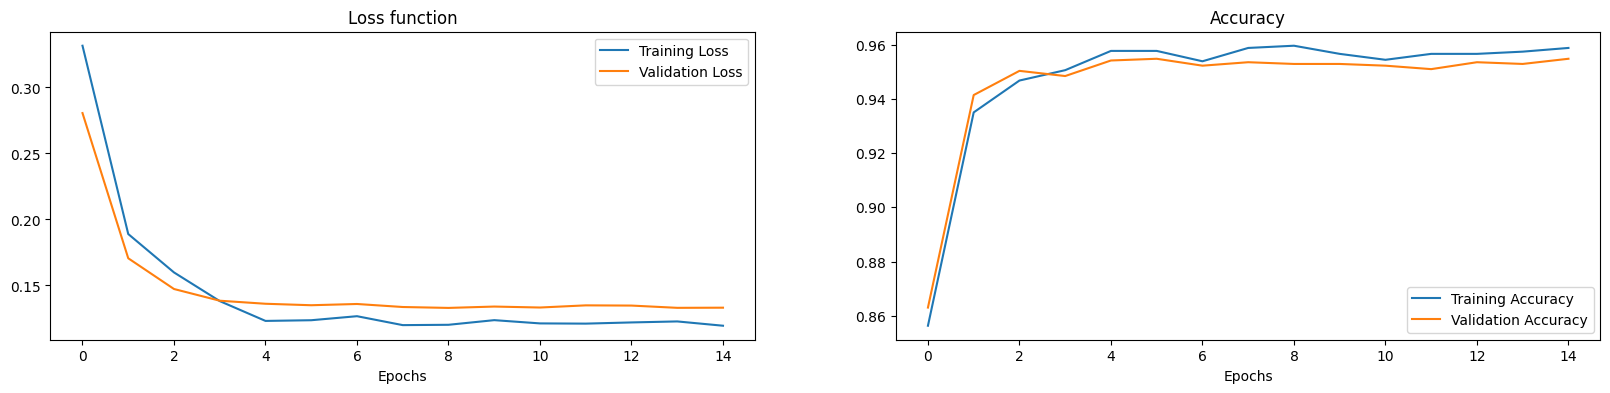

In [ ]:
plt.figure(figsize=(20,4));

# Loss function
plt.subplot(1,2,1)
plt.plot(train_loss_savings, label='Training Loss');
plt.plot(val_loss_savings, label='Validation Loss');
plt.title('Loss function');
plt.xlabel('Epochs');
plt.legend();

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_acc_savings, label='Training Accuracy');
plt.plot(val_acc_savings, label='Validation Accuracy');
plt.title('Accuracy');
plt.xlabel('Epochs');
plt.legend();

In [ ]:
path_best_model = '/content/Pediatric Chest X-ray Pneumonia'



# Save the model
torch.save(model.state_dict(), path_best_model + 'best-model-weighted.pt')

In [ ]:
# Load the best version of the model
model.load_state_dict(torch.load(path_best_model + 'best-model-weighted.pt'))

<All keys matched successfully>

In [ ]:
test_transform = transforms.Compose([
                     transforms.Resize((256, 256)),
                     transforms.CenterCrop(224),
                     transforms.ToTensor()])

test_data = datasets.ImageFolder('test', transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [ ]:
def get_probs_and_preds(model, loader):

    model.eval()

    images_savings = []
    labels_savings = []
    probs_savings  = []
    preds_savings  = []

    #---------------------------------------------------------- Batch-loop ---------#
    for images, labels in iter(loader):                                             #
        images, labels = images.to(device), labels.to(device)                       #
        #------------------------------------------------------ Evaluation ----#    #
        with torch.set_grad_enabled(False):                                    #    #
            output = model(images)                                             #    #
            output = F.softmax(output)                                         #    #
            probabilities, predictions = torch.max(output, dim=1)              #    #
        #----------------------------------------------------------------------#    #
        images_savings.append(images.cpu())                                         #
        labels_savings += labels.tolist()                                           #
        probs_savings  += probabilities.tolist()                                    #
        preds_savings  += predictions.tolist()                                      #
    #-------------------------------------------------------------------------------#

    # Accuracy
    correct_elements = 0
    for i in range(len(labels_savings)):
        if labels_savings[i] == preds_savings[i]:
            correct_elements += 1
    accuracy = correct_elements/len(labels_savings)

    return images_savings, labels_savings, probs_savings, preds_savings, accuracy

In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on test data
images, labels, probs, preds, accuracy = get_probs_and_preds(model, test_loader)

# Calculate additional metrics
report = classification_report(labels, preds)

# Print results
print(f'Accuracy on test: {accuracy:.4f}')
print(report)

Accuracy on test: 0.8878
              precision    recall  f1-score   support

           0       0.96      0.74      0.83       234
           1       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.87       624
weighted avg       0.90      0.89      0.88       624



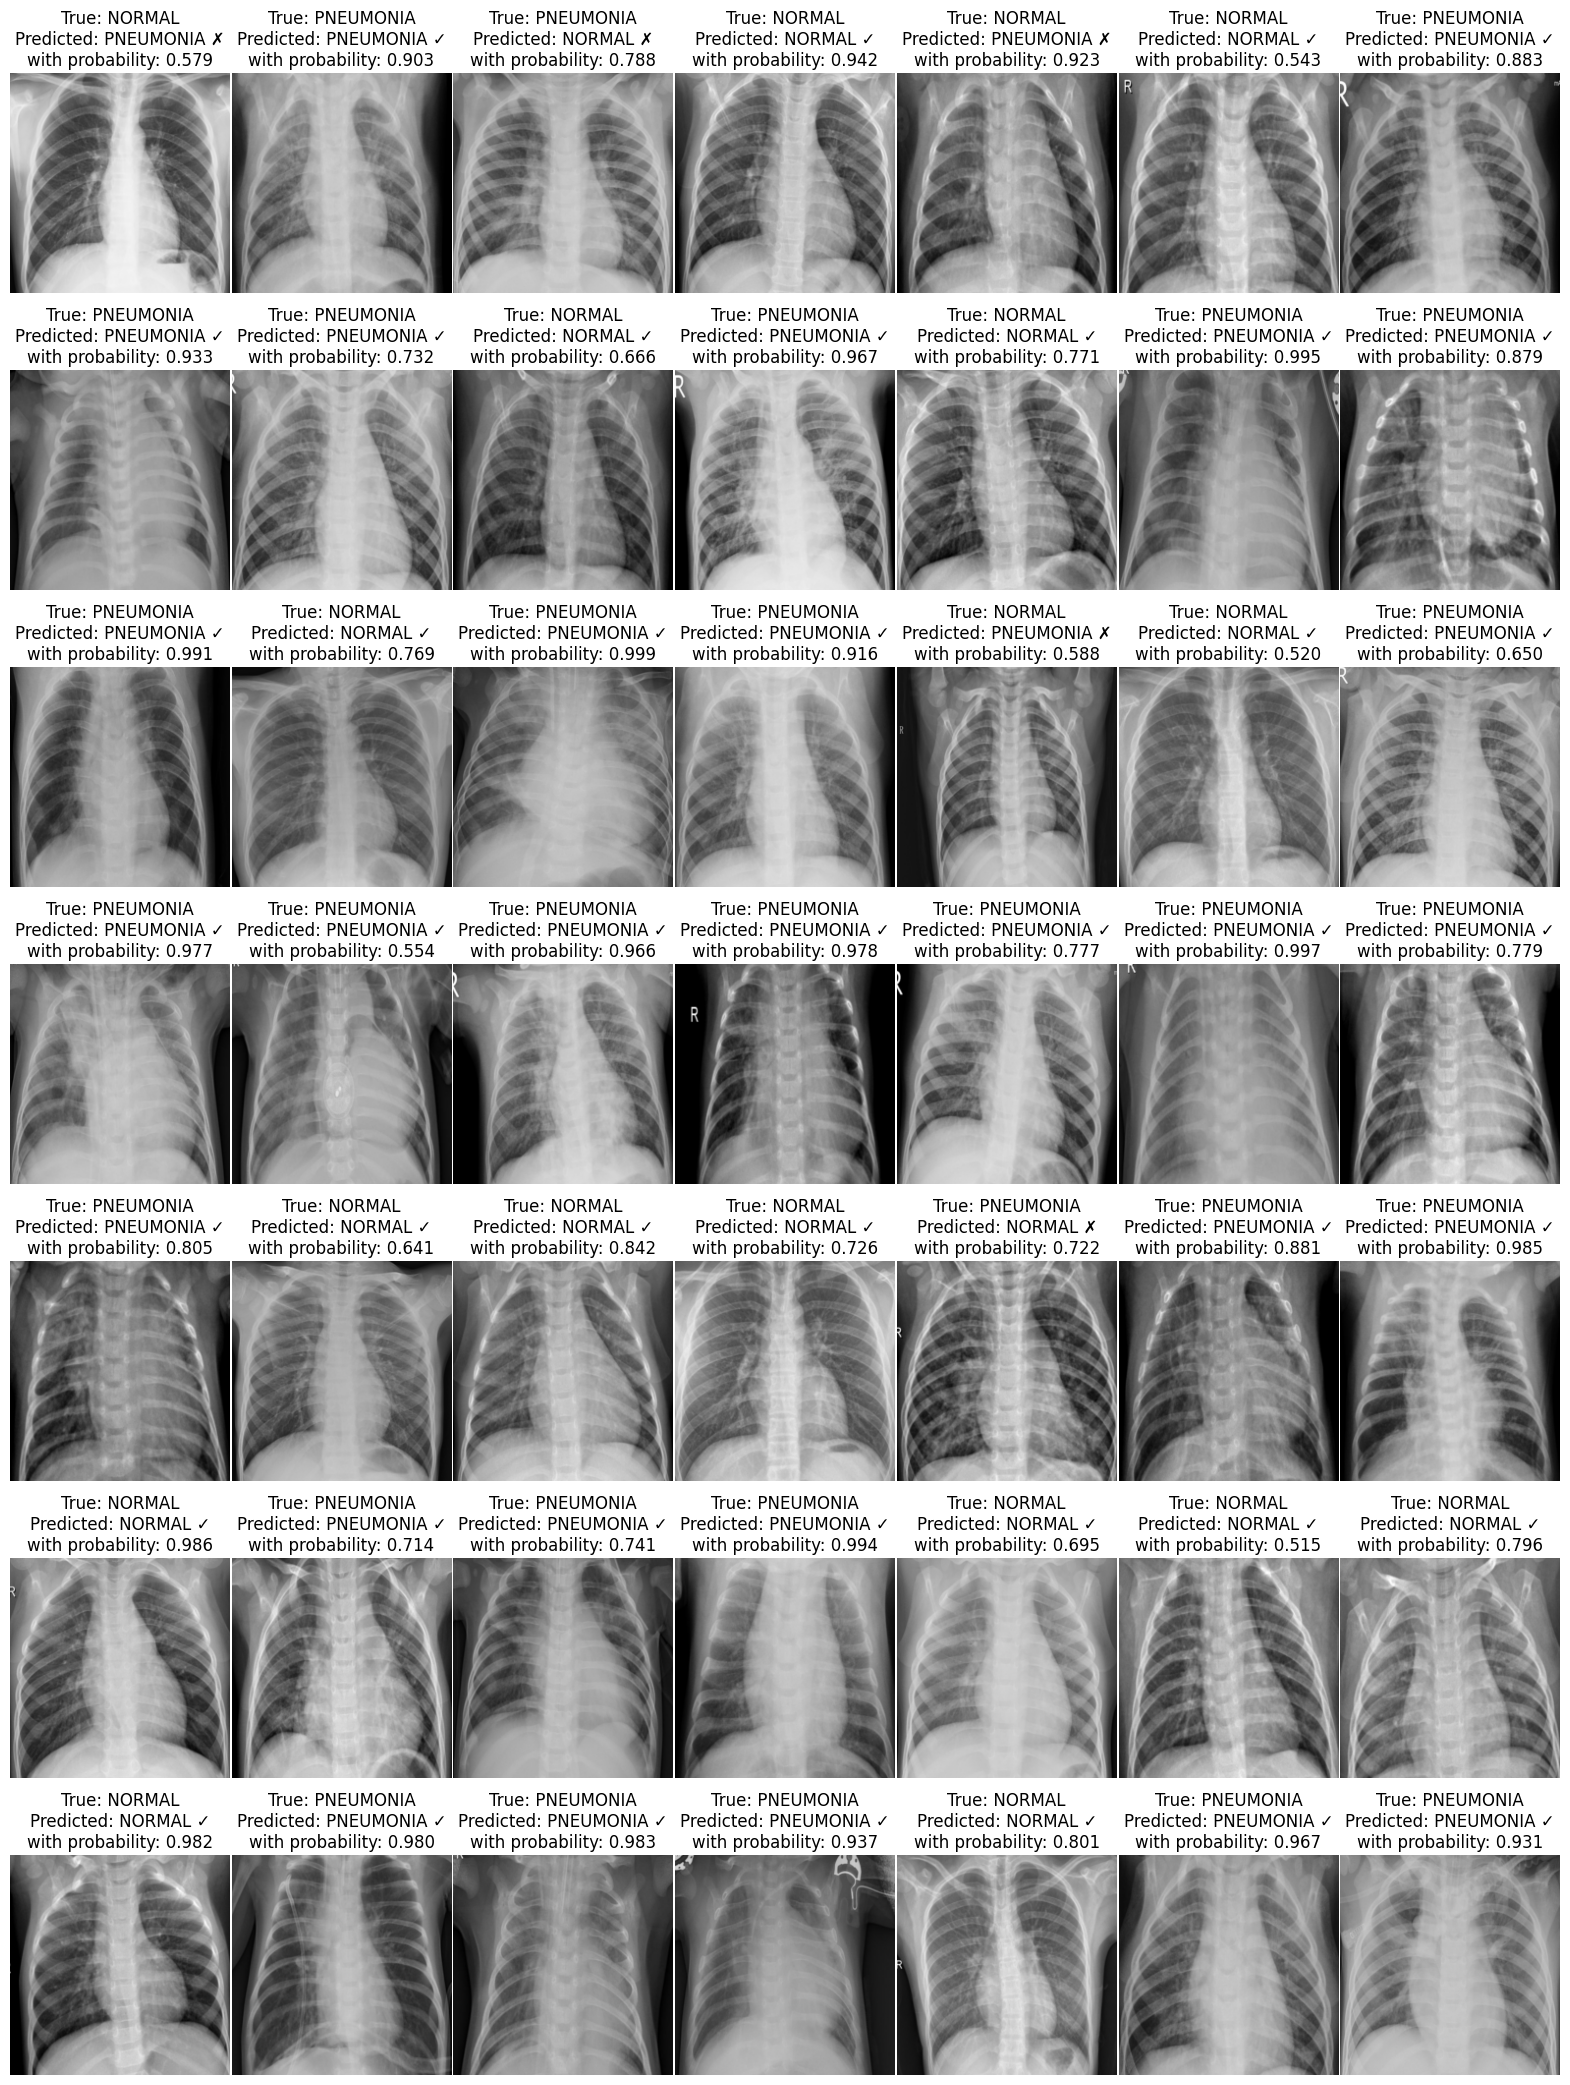

In [ ]:
plt.figure(figsize=(20, 26))
n_rows = 7
n_cols = 7

# Display images
for i in range(n_rows*n_cols):
  text_true = 'True: ' + class_index[labels[i]]
  text_pred = '\nPredicted: ' + class_index[preds[i]]
  text_prob = '\nwith probability: ' + str(probs[i])[:5]

  if labels[i] == preds[i]:
      text_correct = ' ✓'
  else:
      text_correct = ' ✗'

  # Plot the image
  plt.subplot(n_rows, n_cols, i+1)
  plt.imshow(np.transpose(images[0][i].numpy(), (1, 2, 0)))
  plt.title(text_true + text_pred + text_correct + text_prob)
  plt.axis('off')

plt.subplots_adjust(wspace=.01, hspace=.35)

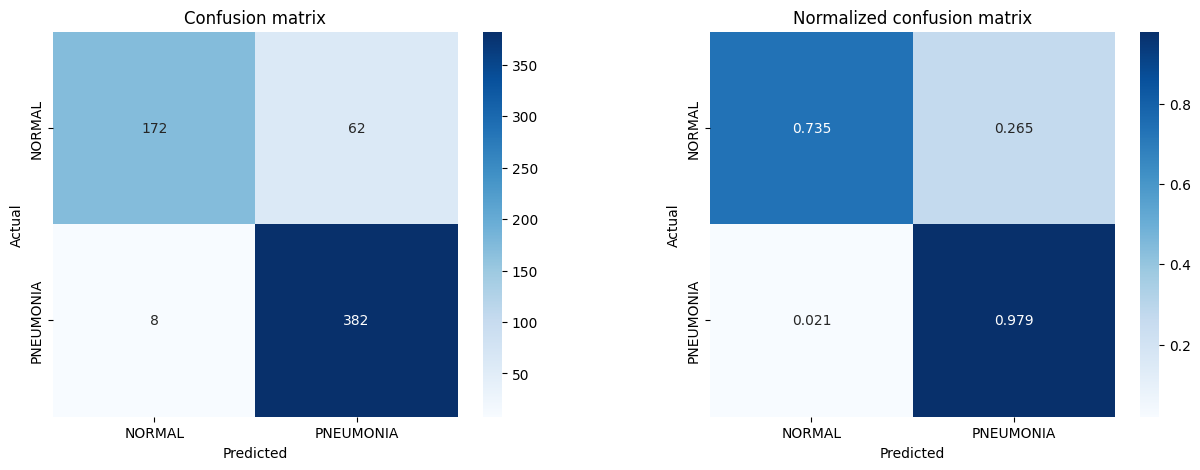

In [ ]:
cm = confusion_matrix(labels, preds)

# Normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Ticklables
ticklabels = class_index.values()

# Plot
fig, ax = plt.subplots(figsize=(15,5))

# Confusion matrix
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

# Normalized confusion matrix
plt.subplot(1,2,2)
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=ticklabels, yticklabels=ticklabels, cmap=plt.cm.Blues);
plt.title('Normalized confusion matrix');
plt.xlabel('Predicted');
plt.ylabel('Actual');

plt.subplots_adjust(wspace=.3)

In [ ]:
transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.CenterCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.RandomGrayscale(),
                    transforms.RandomAffine(translate=(0.05, 0.05), degrees=0),
                    transforms.ToTensor()])

In [ ]:

import torch
from PIL import Image
from torchvision import transforms

In [ ]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Upload the image file
uploaded = files.upload()

# Get the uploaded image data
image_data = uploaded[next(iter(uploaded))]

# Convert the image data to a PIL Image object
img = Image.open(BytesIO(image_data))

Saving person1_virus_13.jpeg to person1_virus_13.jpeg


In [ ]:

input_image = img.convert('RGB')
input_tensor = transform(input_image).unsqueeze(0)
# Pass the input tensor through the model
with torch.no_grad():
    model.eval()
    output = model(input_tensor.to(device))

# Mapping of class labels to names
class_names = {0: 'normal', 1: 'pneumonic'}

# Get the predicted class index
_, predicted = torch.max(output.data, 1)
class_index = predicted.item()

# Look up the class name and print it out
class_name = class_names[class_index]
print('Predicted class: ', class_name)

Predicted class:  pneumonic
